# Setting up the working environment

In [1]:
environment = "COLAB" # COLAB, SSH
debug = False

In [2]:
if environment == "COLAB":
    from google.colab import drive
    import sys
    drive.mount('/content/drive')
    #sys.path.append('/content/drive/MyDrive/Colab Notebooks/Individual Project')
    sys.path.append('/content/drive/Othercomputers/MacBookPro/jupyter_notebooks')
else: 
    ! ls

Mounted at /content/drive


In [ ]:
if environment == "COLAB":
    ! cd 'drive/Othercomputers/MacBookPro/jupyter_notebook'

/bin/bash: line 0: cd: drive/Othercomputers/MacBookPro/jupyter_notebook: No such file or directory


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import seaborn as sn
import os
from utils import visualization as v
from utils import data
from utils.data import NeRFDataset


# We set a random seed to ensure that results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


## Download the data

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

--2022-05-08 21:32:35--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bmild.com/nerf/tiny_nerf_data.npz [following]
--2022-05-08 21:32:36--  https://bmild.com/nerf/tiny_nerf_data.npz
Resolving bmild.com (bmild.com)... 216.239.38.21, 216.239.34.21, 216.239.36.21, ...
Connecting to bmild.com (bmild.com)|216.239.38.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bmild.github.io/nerf/tiny_nerf_data.npz [following]
--2022-05-08 21:32:36--  https://bmild.github.io/nerf/tiny_nerf_data.npz
Resolving bmild.github.io (bmild.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bmild.github.io (bmild.github.io)|185.199.108.153|:443... connected.
HTTP re

# Understanding the Data

The input of the MLP network that will conform the Neural Radiance Field Scene Representation is meant to be a 3D location $\mathbf{x} = (x,y,z)$ and a 2D viewing direction $(\theta, \phi)$. 


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=10OuT4HyclVgcAoR7u7j8MMOI1aw4o3a0" alt="NeRF MLP" width="400"/>
</p>
<p align="center">
<b>NeRF MLP [source: <a href="https://www.matthewtancik.com/nerf">NeRF Page</a>]</b>
</p>

However, the available data in the dataset consists of images, camera poses, and a focal length. Therefore, **we will have to convert each pixel of the images to a 3D location and a 2D viewing direction with the camera pose and the corresponding focal length**.

## Camera projection

First of all, we need to understand that the image is a projection of the real world to the image frame. Specifically, the projection can be splitted in different transformations: 
$$
\begin{aligned}
world\ coords\ [3D] → camera\ coords\ [3D] → image\ coords\ (image\ plane)\ [2D] → pixel\ coordinates\ [2D].
\end{aligned}
$$

1. We can express the **world coordinates in the camera frame** if we have the transformation between the world frame and the camera frame $T_{c \rightarrow w}$. This transformation consists in a Rigid Transformation (rotation + translation) between world and camera coordinate systems.


$$
\begin{aligned}
{}^{c}P = T_{c \rightarrow w}\ {}^{w}P \hspace{2cm} \begin{bmatrix}
{}^{c}X\\
{}^{c}Y\\
{}^{c}Z
\end{bmatrix} =  \mathbf{R} \begin{bmatrix}
{}^{w}X\\
{}^{w}Y\\
{}^{w}Z\\
\end{bmatrix} + \mathbf{t} \hspace{2cm} \begin{bmatrix}
{}^{c}X\\
{}^{c}Y\\
{}^{c}Z\\
1
\end{bmatrix} = \begin{bmatrix}
\mathbf{R} & \mathbf{t}\\
0 & 1
\end{bmatrix} \begin{bmatrix}
{}^{w}X\\
{}^{w}Y\\
{}^{w}Z\\
1
\end{bmatrix} \hspace{2cm} \begin{bmatrix}
{}^{c}X\\
{}^{c}Y\\
{}^{c}Z\\
1
\end{bmatrix} = \begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_{x}\\
r_{21} & r_{22} & r_{23} & t_{y}\\
r_{31} & r_{32} & r_{33} & t_{z}\\
0 & 0 & 0 & 1
\end{bmatrix} \begin{bmatrix}
{}^{w}X\\
{}^{w}Y\\
{}^{w}Z\\
1
\end{bmatrix} 
\end{aligned}
$$

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1W8J1905I7xJxds5GlOGr65uqwEH73z3P" alt="world2cam" width="400"/>
</p>

<p align="center">
<b>World frame to camera frame [source: adaptated from the Imperial College Computer Vision course' slides]</b>
</p>

<ul>
Fortunately, the transformation matrix is contained within the camera poses and we can transform the coordinates from the world frame to the camera frame and more importantly from the camera frame to the world frame by using the inverse. In this case, we will have to use the inverse of the rigit transformation, which is also a rigid transformation:
</ul>

$$
\begin{aligned}
T^{-1}_{(R, t)} = T_{(R^{T}, -R^{T} t)}
\end{aligned}
$$

2. Once the elements are expressed in the camera frame, we can project them in the image plane. We can do so by using Thales' theorem of similar triangles:

$$
\begin{aligned}
x = f \frac{{}^{c}X}{{}^{c}Z} \hspace{2cm} y = f \frac{{}^{c}Y}{{}^{c}Z} 
\end{aligned}
$$


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1-L2w4Kyf2o9MTu3dh3VK6PCQBr0IRt4G" alt="cam2img" width="600"/>
</p>

<p align="center">
<b>Projection to the image frame [source: adaptated from the Imperial College Computer Vision course' slides]</b>
</p>

<ul>Note that for any point $(x, y)$ in the Euclidean plane its representation in the projective plane is simply $(x, y, 1)$. Moreover, we can represent the same point in homogeneous coordinates by adding a third coordinate with a 3D point $(x', y', z')$ such as:</ul>

$$
\begin{aligned}
x = \frac{x'}{z'} \hspace{2cm} y = \frac{y'}{z'} \hspace{2cm} \begin{bmatrix} x'\\ y'\\ z'\end{bmatrix} = \begin{bmatrix} f & 0 & 0 & 0\\
0 & f & 0 & 0\\
0 & 0 & 1 & 0\end{bmatrix} \begin{bmatrix} {}^{c}X\\ {}^{c}Y\\ {}^{c}Z\\ 1 \end{bmatrix}
\end{aligned}
$$

3. The image coordinates above are not expressed in pixel coordinates yet. To convert to pixel coordinates we are not going to consider the center of the image $(x_0, y_0)$ as the origin of our coordinate system. We will add the center of the image to move the origint ot the top-left corner:

$$
\begin{aligned}
u = x + x_0 \hspace{2cm} v = y + y_0
\end{aligned}
$$

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1IjlQqVSv7wjLtTeTJH49AKZpuoOTsORR" alt="cam2img" width="400"/>
</p>

<p align="center">
<b>Image plane coords to pixel coords [source: authors' image]</b>
</p>

<ul>This can be further expressed as:</ul>

$$
\begin{aligned}
\begin{bmatrix} u'\\ v'\\ w'\end{bmatrix} = \begin{bmatrix} {}^{c}Z\ u\\ {}^{c}Z\ v\\ {}^{c}Z\end{bmatrix} = \begin{bmatrix} f & 0 & x_0 & 0\\
0 & f & y_0 & 0\\
0 & 0 & 1 & 0\end{bmatrix} \begin{bmatrix} {}^{c}X\\ {}^{c}Y\\ {}^{c}Z\\ 1 \end{bmatrix}
\end{aligned}
$$

<ul>And the matrix $C_{in} = \begin{bmatrix} f & 0 & x_0 & 0\\
0 & f & y_0 & 0\\
0 & 0 & 1 & 0\end{bmatrix}$ is called camera intrisics as it represents internal properties of the camera such as the focal length and the center of the image plane.</ul> 


## NeRF Dataset

The data available in the NeRF Dataset consists of the different images captured from different points of view with its corresponding camera extrinsics and intrinsics. 

There are different datasets with different formats: 

### [Tiny NeRF](https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz)


The camera extrinsics are given within the *pose* matrix (```data["poses"]```). Each *pose* consists of the transformation matrix $\begin{bmatrix}\mathbf{R} & \mathbf{t}\end{bmatrix}$ where the left 3x3 matrix is the rotation matrix $\mathbf{R}$ and the transformation matrix $\mathbf{t}$ as the right 3x1 matrix.

We can infer the image height and width from the images (```data["images"]```) itself and the focal length is given as an additional field of the data dictionary (i.e., ```data["focal"]```). 

### [NeRF synthetic](https://drive.google.com/drive/folders/1JDdLGDruGNXWnM1eqY1FNL9PlStjaKWi)

The transformation matrix is given for each frame, and the image height and width can also be infered from the images. To obtain the focal length, we can use the horizontal field of view (```camera_angle_x```) with the following equation:

$$
\begin{aligned}
focal = \frac{image\_width}{2\ tan(\frac{camera\_angle\_x}{2})} 
\end{aligned}
$$

### [NeRF LLFF](https://drive.google.com/drive/folders/14boI-o5hGO9srnWaaogTU5_ji7wkX2S7)

The camera extrinsics are also given within the *pose* matrix. In this case each *pose* has $\begin{bmatrix}\mathbf{R} & \mathbf{t}\end{bmatrix}$ as the left 3x4 matrix and ```[image height, image width, focal length]``` as the right 3x1 matrix.

\\

It is worth noting that in all the datasets, the first 3x3 block in the *pose* matrix (i.e., the rotation matrix $\mathbf{R}$ from the Transformation matrix) corresponds to the camera’s point of view. In comparison with other frameworks, the $\mathbf{R}$ matrix is in the form ```[down, right, back]``` or ```[-y, x, z]``` and the camera is pointing torwards ```-z```, instead of ```[right up back]``` as in OpenGL format. However, NeRF uses the same pose coordinate system as in OpenGL which is the reason why we must fix it after loading, note the NeRF dataloader's transformation in the image below, and the signs of the coordinates in the following line of code:

```
directions = torch.stack([xx, -yy, -torch.ones_like(xx)], dim=-1) 
```

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1x9Vx7_lz-LopoHHJDkI23wWTjOy6NuE6" alt="cam2img" width="600"/>
</p>

<p align="center">
<b>Different coordinate frames used by different frameworks [source: @ziruiwang_ox twitter]</b>
</p>


In [ ]:
if debug:
    # Load input images, poses, and intrinsics
    data = np.load("tiny_nerf_data.npz")

    # Images - shape: (num_images, height, width, channels)
    images = data["images"]
    num_images, height, width, num_channels = images.shape

    # Camera extrinsics
    tform_cam2world = data["poses"]
    tform_cam2world = torch.from_numpy(tform_cam2world).to(device)

    # Focal length (intrinsics)
    focal_length = data["focal"]
    focal_length = torch.from_numpy(focal_length).to(device)

    hwf = (height, width, focal_length)

    # Random example
    i_img = np.random.randint(low=0, high=num_images)
    plt.imshow(images[i_img])
    plt.show()

    print(f"\nFocal length: {focal_length}")
    print(f"\nTransformation matrix [R t]: \n{tform_cam2world[i_img,:3,:4]}")
    print(f"\nImage height, Image width, Focal length [H W F]: \n{(height, width, focal_length)}")

## Getting the rays

The process above consists of the forward projection (i.e., passing from the 3D world coordingates to the 2D image's pixels). However, we need to do the inverse process:

1. Pass from pixel coordinates to image plane. Given the $height$ and the $width$ we know that $(x_0, y_0)$ is going to be $(\frac{width}{2}, \frac{height}{2})$ so we can pass the pixel coordinates to the image coordinates (i.e. the coordinates of the projection in the image plane) as follows:

$$
\begin{aligned}
x = u - \frac{width}{2} \hspace{2cm} y = v - \frac{height}{2}
\end{aligned}
$$

2. From the coordinates in the image plane we will get the 3D coordinates in the camera frame. From before we now:

$$
\begin{aligned}
x = f \frac{{}^{c}X}{{}^{c}Z} \hspace{2cm} y = f \frac{{}^{c}Y}{{}^{c}Z}
\end{aligned}
$$

<ul>So, now, we can get the 3D coordinates in the camera frame as follows:</ul>

$$
\begin{aligned}
{}^{c}X = \frac{x\ {}^{c}Z}{f} \hspace{2cm} {}^{c}Y = \frac{y\ {}^{c}Z}{f}
\end{aligned}
$$

<ul>Therefore, we can pass from pixel coordinates to 3D coordinates in the camera frame, with the following equation: </ul>

$$
\begin{aligned}
{}^{c}X = \frac{(u - \frac{width}{2})\ {}^{c}Z}{f} \hspace{2cm} {}^{c}Y = \frac{(v - \frac{height}{2})\ {}^{c}Z}{f}
\end{aligned}
$$

❓ Why ${}^{c}Z$ is considered to be 1 in NeRF❓ Is it because there is a convention in ray-tracing where the objects in the camera frame are placed exactly 1 unit away from the camera's origin❓

3. Finally, we need to transform this coordinates to the world frame and we will get the directions of the rays. Considering that the camera origin in the camera frame was considered to be in the $(0,0,0)$ coordinate, the origin of the rays will be just the translation from the camera frame to the world frame.


In [ ]:
def get_rays_origins_and_directions(height, width, focal_length, pose):

    rotation = pose[:3, :3]
    translation = pose[:3, -1]

    # Obtain each pixel coordinates (u, v)
    uu, vv = torch.meshgrid(torch.arange(width), torch.arange(height), indexing='xy')
    uu, vv = uu.to(focal_length).transpose(-1, -2), vv.to(focal_length).transpose(-1, -2)

    # Pass from pixel coordinates to image plane (uu - width * .5) and (vv - height * .5)
    # and from image plane to 3D coordinates in the camera frame (/focal_length)
    xx = (uu - width * .5) / focal_length
    yy = (vv - height * .5) / focal_length

    # For any point (x, y) in the Euclidean plane its representation in the 
    # projective plane is simply (x, y, 1).
    # 
    # R matrix is in the form [down right back] instead of [right up back] 
    # which is why we must fix it.
    #
    # Given the assumptions above, we are going to create, for each pixel
    # its corresponding direction vector considering the camera's point of 
    # view (i.e., the R matrix)

    directions = torch.stack([xx, -yy, -torch.ones_like(xx)], dim=-1) 
    ray_directions = torch.sum(directions[..., None, :] * rotation, dim=-1)
    
    ray_origins = translation.expand(ray_directions.shape)
    return ray_origins, ray_directions

## Sampling 3D points

Although it is inefficient to not use hierarchical sampling, for the sake of learning to perform volume sampling we will start by creating $N$ query points along each camera ray. We will use stratified sampling to get the different $N$ locations. Specificaly, from a minimum distance to the origin in the direction of the ray to a maximum distance in the same direction, we will create homogeneous divisions and then we will apply random sampling within each division. 

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1ZBwWTsoQvdMcXhmNr8Xv_6r_7V50SSz2" alt="cam2img" width="600"/>
</p>
<p align="center">
<b>Stratified ray sampling [source: <a href="https://keras.io/examples/vision/nerf/">keras</a>]</b>
</p>

In [ ]:
def get_sampling_locations(rays_o, rays_d, near, far, n_samples, stratified=True):
    z_locations = torch.linspace(near, far, n_samples).to(rays_d)
    
    if stratified:
        # Generate for each ray, n_samples of uniform noise
        noise = torch.rand(list(rays_d.shape[:-1]) + [n_samples]).to(rays_d)
        
        # Limit the noise values from 0 to the length of the division
        noise *= (far-near)/n_samples

        z_locations = z_locations + noise

    # Need to broadcast the ray direction to each location
    locations = rays_o[...,None,:] + rays_d[...,None,:] * z_locations[...,:,None]

    locations = torch.reshape(locations, [-1,n_samples,3])
    z_locations = torch.reshape(z_locations, [-1,n_samples])
    
    return locations, z_locations

if debug:
    N_samples = 32
    rays_o, rays_d = get_rays_origins_and_directions(height, width, focal_length, tform_cam2world[0])

    rays_o_flat = torch.reshape(rays_o, [-1, 3])
    rays_d_flat = torch.reshape(rays_d, [-1, 3])
    locations_flat, z_locations_flat = get_sampling_locations(rays_o_flat, rays_d_flat, near=2, far=6, n_samples=N_samples)

    view_dirs = rays_d_flat
    view_dirs = view_dirs / torch.norm(view_dirs, dim=-1, keepdim=True)

# Optimizing a Neural Radiance Field (I)


## Positional Encoding

Mapping the inputs (i.e., 3D coordinates and viewing directions) to a higher-dimensional space before passing them to the neural network allows approximating easily a higher frequency function. Hence, the radiance field would be able to contain higher frequency variation both in color and geometry.

Therefore, we will map the input data from $\mathbb{R}$ into a higger dimensional space $\mathbb{R}^{2L}$.

To do so, we will use different trigonometric functions with different periods/frequencies (one for each dimension), as following:

$$
\gamma(p) = (sin (2^0 \pi p), cos (2^0 \pi p), \dots , sin (2^{L-1} \pi p), cos (2^{L-1} \pi p))
$$

This encoding is applied separately to each of the three coordinate values in x (which are normalized to lie in [−1, 1]) and to the three components of the Cartesian viewing direction unit vector $\mathbf{d}$ (which by construction lie in [−1, 1]). In the original paper, they set $L = 10$ for $\gamma(x)$ and $L = 4$ for $\gamma(\mathbf{d})$.

The spacing between the frequencies can be both linear or logarithmic.


In [ ]:
def positional_encoding(input, L=6, log_sampling=False):

    if log_sampling:
        freq_bands = 2.**torch.linspace(0., L-1, L)
    else:
        freq_bands = torch.linspace(2.**0., 2.**(L-1), L)

    enc = [input]
    for f in freq_bands:
        for fn in [torch.sin, torch.cos]:
            enc.append(fn(f * input))
            
    return torch.cat(enc, dim=-1)

# Creating the model

Refering to the [paper](https://arxiv.org/abs/2003.08934) and its [supplementary material](https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123460392-supp.pdf) we know that the MLP first processes the input 3D coordinate $\mathbf{x}$ with 8 fully-connected layers, using ReLU activations and 256 channels per layer. Then, it outputs the volume density $\sigma$ and a 256-dimensional feature vector.

To obtain the view-dependent RGB radiance, the feature vector is concatenated with the camera ray's viewing direction and passed to an andditional fully-connected layer using 128 channels and ReLU activation.

A final layer with a sigmoid activation, outputs the emitted RGB radiance at position $\mathbf{x}$, as viewed by a ray with direction $\mathbf{d}$.

Inspired by the DeepSDF architecture, the authors also suggest including a skip connection that concatenates this input to the fifth layer’s activation.

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1JLPSqw9mHtj-hVZrF8ZBRom_nIoBqKsM" alt="cam2img" width="600"/>
</p>


<p align="center">
<b> NeRF architecture [source: <a href="https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123460392-supp.pdf">NeRF paper supplementary material</a>]</b>
</p>


In [ ]:
class NeRFModel(nn.Module):

    def __init__(self, D=8, W=256, input_ch=3, view_dir_ch=3, output_ch=4, 
                 skips=[4], viewing_direction=True, L_x=10, L_d=4, pos_enc=True):
        super(NeRFModel, self).__init__()

        self.input_ch = input_ch # size of vector x - usually 3D vector but it can have positional encoding
        self.view_dir_ch = view_dir_ch # we express the 2D viewing direction $(\theta, \phi)$ as a 3D Cartesian unit vector d
        self.output_ch = output_ch # 3 dimensions for the color value/radiance, 1 dimension for the volume density
        self.viewing_direction = viewing_direction
        self.skips = skips
        self.pos_enc = pos_enc

        if not pos_enc:
            L_x = L_d = 0

        self.L_x = L_x
        self.L_d = L_d

        volume_density_layers = [nn.Linear(in_features=input_ch + input_ch*2*L_x, out_features=W)]

        for l in range(1, D):
            volume_density_layers.append(nn.ReLU())

            if l in skips:
                volume_density_layers.append(nn.Linear(in_features=W + input_ch + input_ch*2*L_x, out_features=W))
            else:
                volume_density_layers.append(nn.Linear(in_features=W, out_features=W))

        if viewing_direction:
            self.volume_density_out = nn.Sequential(nn.Linear(in_features=W, out_features=1),
                                                    nn.ReLU())
            self.feature_vector = nn.Linear(in_features=W, out_features=W)

            radiance_layers = [nn.Linear(in_features=W + view_dir_ch + view_dir_ch*2*L_d, out_features=W//2),
                               nn.Linear(in_features=W//2, out_features=3),
                               nn.Sigmoid()]
            self.radiance_layers = nn.Sequential(*radiance_layers)

        else:
            volume_density_layers.append(nn.Linear(in_features=W, out_features=output_ch))

        self.volume_density_layers = nn.Sequential(*volume_density_layers)
    
    def forward(self, x, view_dirs=None):
        enc_x = positional_encoding(x, L=self.L_x)
        out_density = enc_x

        for l, layer in enumerate(self.volume_density_layers):
            out_density = layer(torch.cat((out_density, enc_x), dim=-1) if l/2 in self.skips else out_density)
            
        if self.viewing_direction:
            volume_density = self.volume_density_out(out_density)
            feature_vector = self.feature_vector(out_density)
            enc_view_dirs = positional_encoding(view_dirs, L=self.L_d)
            out_radiance = self.radiance_layers(torch.cat((feature_vector, enc_view_dirs), dim=-1))
            
        else:
            volume_density = torch.relu(out_density[..., 3])
            out_radiance = torch.sigmoid(out_density[..., :3])
            
        return torch.cat((out_radiance, volume_density), dim=-1)

# Volume rendering

We want to compute the expected color $C(\mathbf{r})$ of camera ray with near and far bounds ($t_n$ and $t_f$):

$$
C(\mathbf{r}) = \int^{t_f}_{t_n} T(t)\sigma(\mathbf{r}(t))\mathbf{c}(\mathbf{r}(t), \mathbf{d}) dt
$$

where:

- $\mathbf{r}(t)=\mathbf{o}+t\mathbf{d}$, with camera $\mathbf{o}$, bounded in $[t_n, t_f]$
- $T(t)$ the accumulated transmittance along the ray from $t_n$ to $t$
    - probability that the ray travels from $t_n$ to $t$ without hitting any other particle
- $\sigma(\mathbf{r}(t))$ and $\mathbf{c}(\mathbf{r}(t), \mathbf{d})$ are given by the MLP network $F_{\theta}: (\mathbf{x}, \mathbf{d})$ → $(\mathbf{c}, \sigma)$
    - $\sigma$ → differential probability of a ray terminating at an infinitesimal particle at location $\mathbf{x}$

We cannot compute the continuous integral, and that is the reason why we use stratified sampling when obtaining the rays' 3D locations.

The expected color estimation is then computed as:

$$
\hat{C}(\mathbf{r}) = \sum_{i=1}^{N}T_i(1-e^{-\sigma_i\delta_i})\ \mathbf{c}_i
$$

where:

- $T_i = e^{-\sum_{j=1}^{i-1} \sigma_j \delta_j}  = \prod_{j=1}^{i-1} e^{-\sigma_j \delta_j}$
- $\delta_i=t_{i+1}-t_i$, i.e., distance between adjacent samples

Note that this equation can be understood as a weigthed sum of the sampled colors along the ray:

$$
\hat{C}(\mathbf{r}) = \sum_{i=1}^{N} w_i\ \mathbf{c}_i \hspace{1cm} w_i = T_i(1-e^{-\sigma_i\delta_i})
$$

This weights give an idea of the relevance of each part of the ray regarding the volume information that it reveals. The idea of hierarchical volume sampling relies in taking profit of this weights as it is exposed in the following section.

In [ ]:
def volume_rendering(raw_radiance_density, z_locations, rays_d, raw_noise_std=0.):

    # distance between adjacent samples
    dists = z_locations[..., 1:] - z_locations[..., :-1]

    # last sample' distance is going to be infinity, we represent such distance 
    # with a symbolic high value (i.e., 1e10)
    inf = torch.tensor([1e10]).to(dists)
    dists = torch.concat([dists, torch.broadcast_to(inf, dists[..., :1].shape)], dim=-1)

    # convert the distances in the rays to real-world distances by multiplying 
    # by the norm of the ray's direction
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

    # Adding noise to model's predictions for density helps regularizing the network 
    # during training.
    raw_density = raw_radiance_density[..., 3]
    if raw_noise_std > 0.:
        noise = torch.randn(raw_density.shape).to(raw_density) * raw_noise_std
        raw_density = raw_density + noise

    alpha = 1.0 - torch.exp(-raw_density * dists)

    transmitance = torch.cumprod(1.0 - alpha + 1e-10, dim=-1)

    # exclusive = True, for the first sample the transmitance should be 1 as the
    # probability to travel from one sample to the same sample without hitting any
    # particle is 1
    transmitance = torch.roll(transmitance, 1, -1)
    transmitance[..., 0] = 1.0

    weights = transmitance * alpha
    rgb = torch.sum(weights[..., None] * raw_radiance_density[..., :3], dim=-2)
    return rgb, weights
    
if debug:
    view_dirs_flat = torch.broadcast_to(view_dirs[..., None, :], locations_flat.shape)

    model = NeRFModel()
    model.to(device)

    raw_radiance_density_flat = model(locations_flat, view_dirs=view_dirs_flat)

    rgb_map, weights = volume_rendering(raw_radiance_density_flat, z_locations_flat, torch.reshape(rays_d, [-1, 3])) 
    rgb_map = torch.reshape(rgb_map, rays_d.shape)

    plt.figure(figsize=(10, 4))
    plt.imshow(rgb_map.detach().cpu().numpy())
    plt.show()

# Optimizing a Neural Radiance Field (II)

## Hierarchical volume sampling

Instead of sampling 3D points along all the ray, we can try to focus on those parts of the ray that will give us relevant information of the object's volume.

To do so, we will take advantage of the network's output, specifically the volume density $\sigma(\mathbf{x})$ that represents the differential probability of a ray terminating at an infinitesimal particle at location $\mathbf{x}$. Specifically, if we focus on the way that we render the colors of the camera rays, we can understand such formula as a way of weighting the different colors across the ray. Hence, such weights give us information of the regions that effectively have volume and thus contribut to the expected effect on the final rendering.

$$
\hat{C}(\mathbf{r}) = \sum_{i=1}^{N} w_i\ \mathbf{c}_i \hspace{1cm} w_i = T_i(1-e^{-\sigma_i\delta_i})
$$

If we normalize such weights, we end up with a Probability Density Function (PDF) along the ray which reflects the relevance of each depth in the final rendering. 

$$
\hat{w}_i = \frac{w_i}{\sum^{N_c}_{j=1} w_j}
$$

Now, we can sample a second set of locations from this PDF, using inverse transform sampling, and evaluate this new points together with the previous ones (i.e., the ones obtaines with stratified sampling) with the *fine* network. 

The inverse transform sampling can be performed as following:
* Compute the Cummulative Distribution Function of the obtained PDF, i.e., the integration of the PDF. A cummulative distribution $F_X(x)$ is the probability that a random variable $X$ will have a lower value than $x$: $F_X(x) = P(X \leq x)$ 
* Generate a random number according to a uniform function $U \sim Unif(0,1)$
* Determine the index $j$ such that $\sum_{i=1}^{j-1} p_i \leq U < \sum_{i=1}^j p_i$. In our case, $p_i$ will be the weights of each location $\hat{w}_i$. 
* Take the sample from the location in the index $j$. Hence, the more weight a location has, the more chances it has to be picked in the second set of samples. 

**Actually, we are not going to take exactly the same location as the one associated to the weight $j$**, but one between location $j$ and location $j-1$. The interpolation is going to be made according to the difference between the random value $U$ and the cumulative probability of $j-1$ and $j$ (i.e., $\sum_{i=1}^{j-1} \hat{w}_i$ and $\sum_{i=1}^j \hat{w}_i$) such that:

$$
location = location_{j-1} + \frac{U - \sum_{i=1}^{j-1} \hat{w}_i}{\sum_{i=1}^{j} \hat{w}_i - \sum_{i=1}^{j-1} \hat{w}_i} * (location_j - location_{j-1})
$$

This process is expected to allocate more samples to regions where there is visible content, helping to train quite faster our model.

In [ ]:
def sample_pdf(locations, weights, N_samples=128, plt_fn=None, rays_o=None, rays_d=None):
    weights += 1e-5  # prevent nans
    pdf = weights / torch.sum(weights, dim=-1, keepdim=True)
    
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.concat((torch.zeros_like(cdf[..., :1]), cdf), dim=-1) # prob of being between -1 and 0 is 0
    
    u = torch.rand(list(cdf.shape[:-1]) + [N_samples]).to(cdf)

    js = torch.searchsorted(cdf, u, right=True)
    prev_j = torch.maximum(torch.tensor(0), js-1)
    j = torch.minimum(torch.tensor(cdf.shape[-1]-1), js)

    cdf_prev_j = torch.gather(cdf, dim=-1, index=prev_j)
    cdf_j = torch.gather(cdf, dim=-1, index=j)

    locations_prev_j = torch.gather(locations, dim=-1, index=prev_j)
    locations_j = torch.gather(locations, dim=-1, index=j)

    denom = cdf_j-cdf_prev_j
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom) # avoid division by 0
    t = (u-cdf_prev_j)/denom
    
    samples = locations_prev_j + t * (locations_j-locations_prev_j)

    if plt_fn is not None and rays_o is not None and rays_d is not None:
        plt_fn(pdf, cdf, j, samples)

    return samples

if debug:
    z_locs_mid = .5 * (z_locations_flat[..., 1:] + z_locations_flat[..., :-1])
    samples = sample_pdf(z_locs_mid, 
                        weights[..., 1:-1], 
                        plt_fn=v.plt_first_ray_sampling_pdf, 
                        rays_o=torch.reshape(rays_o, [-1,3]),
                        rays_d=torch.reshape(rays_d, [-1,3]))

# Train NeRF

  0%|          | 0/100000 [00:00<?, ?iteration/s]

Pred 0
query_points depth_values shape torch.Size([10000, 64, 3]) torch.Size([10000, 64])
query_points depth_values shape torch.Size([10000, 64, 3]) torch.Size([10000, 64])
query_points depth_values shape torch.Size([10000, 64, 3]) torch.Size([10000, 64])


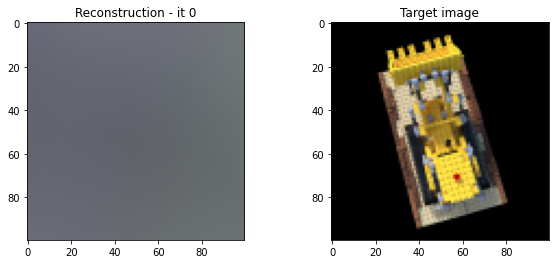

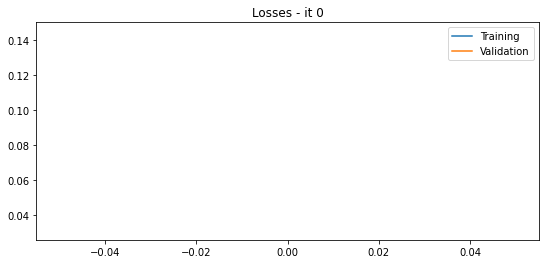

Pred 1
query_points depth_values shape torch.Size([10000, 64, 3]) torch.Size([10000, 64])


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/usr/lib/python3.7/asyncio/base_events.py", li

RuntimeError: ignored

In [ ]:
def validation_view(model, pose_val, hwf, val_target, it, N_samples=64, model_f=None, N_f=128, near=2, far=6):
    model.eval()
    pose_val = pose_val.to(hwf[2])
    
    val_rays = data.get_validation_rays(pose_val, hwf, get_rays_origins_and_directions)
    pred = predict(val_rays, model, N_samples=N_samples, model_f=model_f, N_f=N_f, near=near, far=far)
    rgb_map = pred["rgb_map"] 
    
    rgb_map = torch.reshape(rgb_map, val_target.shape)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_map.detach().cpu().numpy())
    plt.title(f"Reconstruction - it {it}")
    plt.subplot(122)
    plt.imshow(val_target.detach().cpu().numpy())
    plt.title("Target image")
    plt.show()


def run_model(locations, view_dirs, model, batch_size):
    locs_flat = torch.reshape(locations, [-1, locations.shape[-1]])
    
    view_dirs = torch.broadcast_to(view_dirs, locations.shape)
    view_dirs_flat = torch.reshape(view_dirs, [-1, view_dirs.shape[-1]])
    raw_radiance_density_flat = model(locs_flat, view_dirs=view_dirs_flat)

    '''raw_radiance_density_flat=None
    for (locs, view_dirs) in data.batchify(locations, view_dirs, batch_size):
        raw_radiance_density = model(locs, view_dirs=view_dirs)

        if raw_radiance_density_flat is None:
            raw_radiance_density_flat = raw_radiance_density
        else:
            raw_radiance_density_flat = torch.cat((raw_radiance_density_flat, raw_radiance_density))'''

    raw_radiance_density = torch.reshape(raw_radiance_density_flat, 
                                            list(locations.shape[:-1]) + [raw_radiance_density_flat.shape[-1]])
    return raw_radiance_density

def predict(batch_rays, model, N_samples=64, model_f=None, N_f=128, near=2, far=6, raw_noise_std=0.0, batch_size=64):
    
    locations, depths = get_sampling_locations(rays_o=batch_rays[..., :3], 
                                                   rays_d=batch_rays[..., 3:6], 
                                                   near=near, 
                                                   far=far, 
                                                   n_samples=N_samples)
    print("query_points depth_values shape", locations.shape, depths.shape)
    
    view_dirs = batch_rays[..., None, 6:9]
    raw_radiance_density = run_model(locations, view_dirs, model, batch_size)
    rgb_map, weights = volume_rendering(raw_radiance_density, 
                                        depths, 
                                        rays_d=batch_rays[..., 3:6], 
                                        raw_noise_std=raw_noise_std)
    
    if N_f > 0:
        rgb_map_0, weights_0 = rgb_map, weights

        depths_mid = .5 * (depths[..., 1:] + depths[..., :-1])
        depths_f = sample_pdf(depths_mid, weights[..., 1:-1])
        depths_f = depths_f.detach()
        
        depths_new = torch.cat((depths, depths_f), dim=-1)
        depths_new, _ = torch.sort(depths_new, dim=-1)
        locs_f = rays_o[...,None,:] + rays_d[...,None,:] * depths_new[...,:,None]

        raw_radiance_density = run_model(locs_f, view_dirs, model_f)
        rgb_map, weights = volume_rendering(raw_radiance_density, depths_new, 
                                            rays_d, raw_noise_std=raw_noise_std)

    pred = {'rgb_map': rgb_map, 'weights': weights}
    if N_f > 0:
        pred['rgb_map_0'] = rgb_map_0
        pred['weights_0'] = weights_0
    return pred

def train(dataset="tiny_nerf", batch_size=1024*1, lr=2e-5, N_iters=10000, 
          N_samples=64, N_f=128, near=2, far=6, raw_noise_std=0.0):
    
    '''# Load data
    if dataset == "tiny_nerf":
        poses, images, hwf, i_split = data.load_tiny_nerf("tiny_nerf_data.npz", device=device)
        i_train, i_val, i_test = i_split
        
    #Create datasets
    loader_train, loader_val, loader_test = data.create_dataset(poses, 
                                                                images, 
                                                                hwf, 
                                                                i_split, 
                                                                get_rays_origins_and_directions, 
                                                                batch_size,
                                                                device=device)'''
    dataset = NeRFDataset(dataset, "tiny_nerf_data.npz", get_rays_origins_and_directions, device=device)

    # Create models
    model = NeRFModel()
    model.to(device)
    model_f = None

    if N_f > 0:
        model_f = NeRFModel(D=2)
        model_f.to(device)

    # Create optimizer
        optimizer = torch.optim.Adam(list(model.parameters()) + list(model_f.parameters()), lr=lr)

    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_fn = nn.MSELoss()

    # Train
    #train_iterator = iter(loader_train)
    #val_iterator = iter(loader_val)
    training_losses = []
    val_losses = []

    for it in tqdm(range(N_iters), unit="iteration"):

        batch_rays_tr, target_rgb = dataset.next_batch("train")
        batch_rays_val, target_rgb_val = dataset.next_batch("val")

        model.train()
        print(f"Pred {it}")
        pred = predict(batch_rays_tr, model, N_samples=N_samples, model_f=model_f, 
                       N_f=N_f, near=near, far=far, raw_noise_std=raw_noise_std,
                       batch_size=batch_size)

        if N_f > 0:
            loss_c = loss_fn(pred['rgb_map_0'], target_rgb)
            loss_f = loss_fn(pred['rgb_map'], target_rgb)
            loss = loss_c + loss_f
        else:
            loss = loss_fn(pred['rgb_map'], target_rgb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        # ----- VALIDATION LOSS -----
        model.eval()
        pred = predict(batch_rays_val, model, N_samples=N_samples, model_f=model_f, N_f=N_f, near=near, far=far)
        
        if N_f > 0:
            loss_c = loss_fn(pred['rgb_map_0'], target_rgb_val)
            loss_f = loss_fn(pred['rgb_map'], target_rgb_val)
            loss_val = loss_c + loss_f
        else:
            loss_val = loss_fn(pred['rgb_map'], target_rgb_val)

        val_losses.append(loss_val.item())
        
        if it%100 == 0:
            pose, img, hwf = dataset.get_val_pose_img_hwf(0)
            validation_view(model, pose, hwf, img, it=it, N_samples=N_samples, 
                            model_f=model_f, N_f=N_f, near=near, far=far)
            v.plot_losses(training_losses, val_losses, it=it)

torch.autograd.set_detect_anomaly(True)                      
DATASET = "tiny_nerf" # tiny_nerf
train(dataset=DATASET, N_iters=100000, batch_size=1, lr=5e-3, N_f=0, raw_noise_std=.0)

In [ ]:
for i in range(0, 13, 2):
    print(i)